<a href="https://www.kaggle.com/code/mikedelong/what-kind-of-incidents?scriptVersionId=150030306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%env TOKENIZERS_PARALLELISM=false
!pip install bertopic

env: TOKENIZERS_PARALLELISM=false
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819468 sha256=b77d662eb566c2b11264f22c62c931bd04054d899236b9af1f796ff42018a708
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=bfd956639feecd26eb22369f968d57c08858d31be7835a9747a4d2de6896820f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/

In [2]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/ai-incidents/incidents.csv', parse_dates=['date'], index_col=['incident_id']).drop(columns='_id')
# we want year buckets so let's get the years
df['year'] = df['date'].dt.year
df.head()

,date,reports,Alleged deployer of AI system,Alleged developer of AI system,Alleged harmed or nearly harmed parties,description,title,year
incident_id,,,,,,,,
23,2017-11-08,"[242,243,244,245,246,247,248,249,250,253,254,2...","[""navya"",""keolis-north-america""]","[""navya"",""keolis-north-america""]","[""navya"",""keolis-north-america"",""bus-passengers""]",A self-driving public shuttle by Keolis North ...,Las Vegas Self-Driving Bus Involved in Accident,2017
4,2018-03-18,"[629,630,631,632,633,634,635,636,637,638,639,6...","[""uber""]","[""uber""]","[""elaine-herzberg"",""pedestrians""]",An Uber autonomous vehicle (AV) in autonomous ...,Uber AV Killed Pedestrian in Arizona,2018
1,2015-05-19,"[1,2,3,4,5,6,7,8,9,10,11,12,14,15]","[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,2015
18,2015-04-04,"[130,131,132,133,134,135,136,137,138,1367,1368]","[""google""]","[""google""]","[""women""]",Google Image returns results that under-repres...,Gender Biases of Google Image Search,2015
12,2016-07-21,[42],"[""microsoft-research"",""boston-university""]","[""microsoft-research"",""google"",""boston-univers...","[""women"",""minority-groups""]",Researchers from Boston University and Microso...,Common Biases of Vector Embeddings,2016


In [3]:
from plotly.express import histogram
histogram(data_frame=df, x='date')

If we use a scatter plot for the same data we can easily add a trendline.

In [4]:
from plotly.express import scatter
scatter(data_frame=df['year'].value_counts().to_frame().reset_index(), x='year', y='count', trendline='lowess', trendline_color_override='orange')

According to this data incidents certainly seem to be accelerating starting in about 2009.

(-0.5, 1199.5, 1199.5, -0.5)

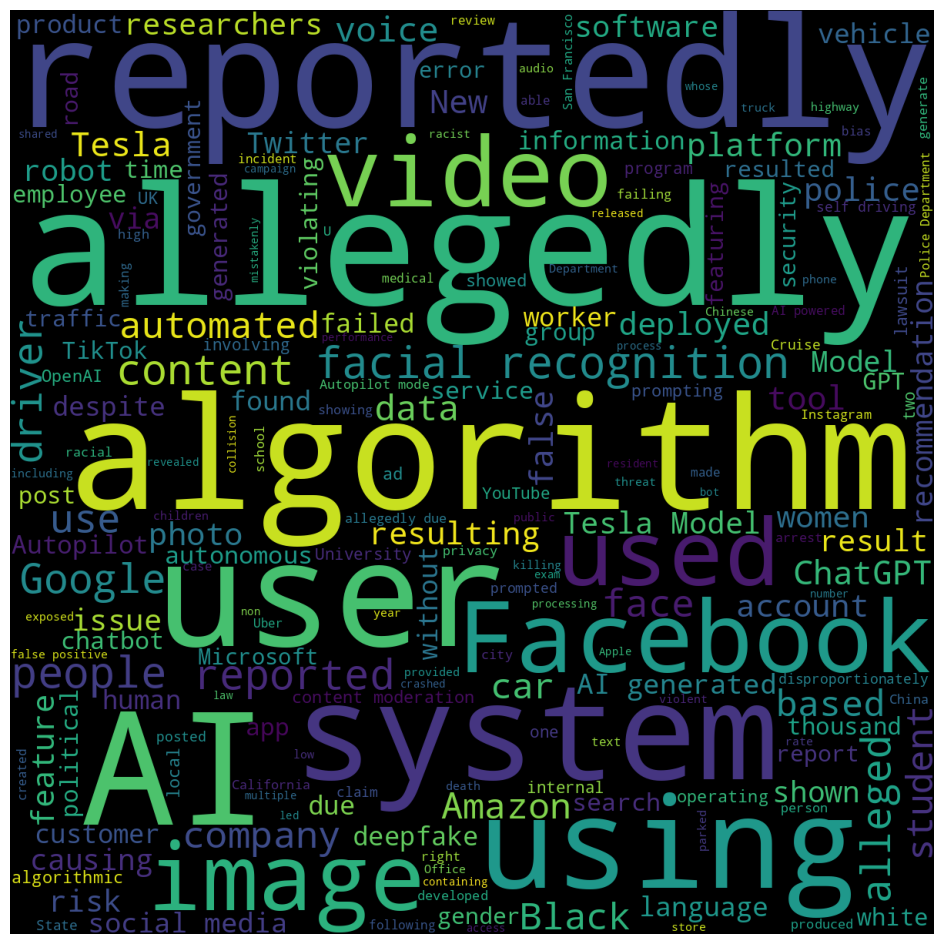

In [5]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

subplots(figsize=(12, 12))
text = ' '.join(df['description'].values)
stopwords = STOPWORDS.union(set('s'))
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=stopwords ).generate(text=text), )
axis('off')

A word cloud will give us a sense of how words feature in the corpus proportionately. If we want to find out what technology was used and what the actual offense was we need to dig a bit deeper than just looking at word freqencies. Let's try just looking at noun/noun phrases.

In [6]:
from collections import Counter
from textblob import TextBlob
from plotly.express import bar
df['noun'] = df['description'].apply(lambda x: TextBlob(x).noun_phrases)
nouns = [item for sublist in df['noun'].values for item in sublist]
count = Counter(nouns)
noun_count_df = pd.DataFrame(data={'noun': list(dict(count).keys()), 'count': list(dict(count).values())}) 
bar(data_frame=noun_count_df.sort_values(ascending=False, by='count').head(n=50), y='noun', x='count', height=900)

This isn't bad: we get a sense of what the technologies are (ai-generated images, facial recognition software, law enforcement software, and self-driving car technology); it's hard to tell what the problematic behavior was according to this analysis.

(-0.5, 1199.5, 1199.5, -0.5)

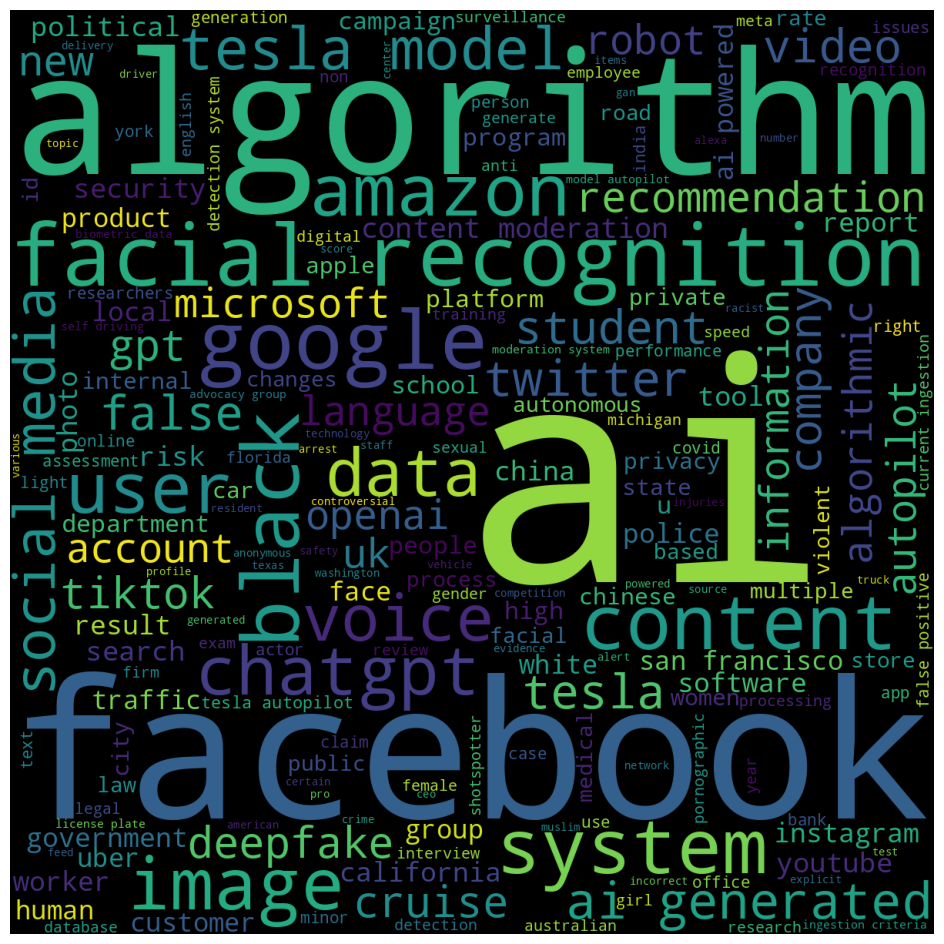

In [7]:
subplots(figsize=(12, 12))
stopwords = STOPWORDS.union(set('s'))
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=stopwords ).generate(text=' '.join(nouns)), )
axis('off')

If we visualize the noun data as a word cloud we see the situation we saw above in the bar chart, but with more data: the incidents talk a lot about the companies involved and about platform technology, but not much about what the problematic behavior was.

In [8]:
from arrow import now
from bertopic import BERTopic
from plotly.express import histogram
from sklearn.feature_extraction.text import CountVectorizer

MAX_DF = 0.5 # this is a guess and we should probably base it on something
MIN_DF = 2 # our documents are short and there is probably no point in keeping any word that appears twice or less
# we can dial this up and down for testing; a full run (1.0) takes nearly seven minutes
SAMPLE_FRACTION = 1.0

time_start = now()
large_model = BERTopic(verbose=True, top_n_words=15, nr_topics=None, language='english', 
                       vectorizer_model=CountVectorizer(stop_words=list(stopwords), lowercase=False, min_df=MIN_DF, max_df=MAX_DF, ))
large_topics, large_probs = large_model.fit_transform(df['description'].sample(frac=SAMPLE_FRACTION, random_state=2023).dropna().values)
print('After {} our model says we have {} topics.'.format(now() - time_start, len(set(large_topics))))
print('And we have {} documents with no topic ({}%).'.format(large_topics.count(-1), round(100 * large_topics.count(-1)/len(large_topics))))
histogram(x=[item for item in large_topics if item > -1], title = 'topic > -1 histogram')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to th

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2023-11-09 16:11:32,414 - BERTopic - Transformed documents to Embeddings
2023-11-09 16:11:41,550 - BERTopic - Reduced dimensionality
2023-11-09 16:11:41,565 - BERTopic - Clustered reduced embeddings


After 0:00:19.214372 our model says we have 14 topics.
And we have 110 documents with no topic (20%).


In [9]:
large_model.visualize_topics(height=800, width=1000)

Very broadly we have four clusters: 
* Autonomous driving 
* Content moderation 
* Generative text and audio
* Images, image processing, etc.
This is part of the answer we want.